In [1]:
import pandas as pd
import numpy as np
from faker import Faker
import uuid
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Faker
fake = Faker()

# Constants
TOTAL_ROWS = 1000
NUM_FRAUD_ROWS = 100  # Total fraudulent rows
NUM_FRAUD_IDS = 50     # Number of unique fraudulent IDs
FRAUD_DUPLICATES = 2   # Number of duplicates per fraud ID (2 for pairing)

# Event and ticket category lists
EVENTS = [
    "Concert A",
    "Concert B",
    "Sports Event A",
    "Sports Event B",
    "Festival A",
    "Festival B",
    "Theater A",
    "Theater B"
]
TICKET_CATEGORIES = ["VIP", "General", "Balcony", "Standing", "Premium", "Economy"]

def generate_wallet_address():
    """Generates a fake Ethereum-like wallet address."""
    return '0x' + ''.join(np.random.choice(list('0123456789abcdef'), size=40))

def generate_event_timestamp():
    """Generates a random event timestamp between Jan 1, 2025 and Dec 31, 2025."""
    start_date = datetime(2025, 1, 1)
    end_date = datetime(2025, 12, 31, 23, 59, 59)
    return fake.date_time_between(start_date=start_date, end_date=end_date)

def generate_transaction_timestamp(event_time):
    """Generates a transaction timestamp before the event timestamp."""
    # Ensure the transaction is at least 1 hour before the event and at most 30 days before
    min_delta = timedelta(hours=1)
    max_delta = timedelta(days=30)
    delta_seconds = np.random.randint(int(min_delta.total_seconds()), int(max_delta.total_seconds()))
    delta = timedelta(seconds=delta_seconds)
    transaction_time = event_time - delta
    return transaction_time

# -- Step 1: Generate a Single Organizer Wallet Address --
organizer_wallet = generate_wallet_address()

# Initialize data dictionary
data = {
    "ID": [],
    "event_timestamp": [],
    "transaction_timestamp": [],
    "event": [],
    "ticket_price": [],
    "ticket_category": [],
    "buyer_wallet_address": [],
    "seller_wallet_address": [],
    "organizer_wallet_address": []
}

# -- Step 2: Generate Fraudulent Transactions --
for _ in range(NUM_FRAUD_IDS):
    # Generate a unique fraudulent ID
    fraud_id = str(uuid.uuid4())

    # Select a random event
    event = np.random.choice(EVENTS)

    # Generate a single event timestamp
    event_time = generate_event_timestamp()

    # Generate a base transaction timestamp
    base_transaction_time = generate_transaction_timestamp(event_time)

    for _ in range(FRAUD_DUPLICATES):
        # Append the same ID for fraud
        data["ID"].append(fraud_id)

        # Event details
        data["event"].append(event)
        data["event_timestamp"].append(event_time)

        # For fraudulent transactions, introduce slight variations in transaction timestamp
        # To simulate duplicate or near-duplicate timestamps, add small random seconds
        variation_seconds = np.random.randint(0, 60)  # Up to 1 minute difference
        transaction_time = base_transaction_time + timedelta(seconds=variation_seconds)
        data["transaction_timestamp"].append(transaction_time)

        # Ticket price (can vary slightly)
        ticket_price = round(np.random.uniform(50, 500), 2)
        data["ticket_price"].append(ticket_price)

        # Ticket category
        ticket_category = np.random.choice(TICKET_CATEGORIES)
        data["ticket_category"].append(ticket_category)

        # Different buyer wallets for each fraud transaction
        buyer_wallet = generate_wallet_address()
        data["buyer_wallet_address"].append(buyer_wallet)

        # Seller wallet: Must differ from organizer_wallet
        while True:
            seller_wallet = generate_wallet_address()
            if seller_wallet != organizer_wallet:
                break
        data["seller_wallet_address"].append(seller_wallet)

        # Organizer wallet: Same for all rows
        data["organizer_wallet_address"].append(organizer_wallet)

# -- Step 3: Generate Legitimate Transactions --
NUM_LEGIT_ROWS = TOTAL_ROWS - NUM_FRAUD_ROWS  # 900

for _ in range(NUM_LEGIT_ROWS):
    # Generate unique ID
    legit_id = str(uuid.uuid4())
    data["ID"].append(legit_id)

    # Select a random event
    event = np.random.choice(EVENTS)
    data["event"].append(event)

    # Generate event timestamp
    event_time = generate_event_timestamp()
    data["event_timestamp"].append(event_time)

    # Generate transaction timestamp
    transaction_time = generate_transaction_timestamp(event_time)
    data["transaction_timestamp"].append(transaction_time)

    # Generate ticket price (e.g., between 50 to 500 units)
    ticket_price = round(np.random.uniform(50, 500), 2)
    data["ticket_price"].append(ticket_price)

    # Select a random ticket category
    ticket_category = np.random.choice(TICKET_CATEGORIES)
    data["ticket_category"].append(ticket_category)

    # Generate buyer wallet
    buyer_wallet = generate_wallet_address()
    data["buyer_wallet_address"].append(buyer_wallet)

    # Seller wallet: 
    # For legitimate transactions, assume seller is the organizer
    seller_wallet = organizer_wallet  # Seller is the organizer
    data["seller_wallet_address"].append(seller_wallet)

    # Organizer wallet: Same for all rows
    data["organizer_wallet_address"].append(organizer_wallet)

# -- Step 4: Create DataFrame --
df = pd.DataFrame(data)

# -- Step 5: Shuffle the DataFrame --
# To mix fraudulent and legitimate transactions
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# -- Step 6: Sort by transaction timestamp --
df = df.sort_values(by="transaction_timestamp").reset_index(drop=True)

# -- Step 7: Save to CSV --
df.to_csv("fake_blockchain_transactions_with_fraud.csv", index=False)



In [2]:
# -- Step 7: Save to JSON -- # <- Modified Section
df.to_json(
    "fake_blockchain_transactions_with_fraud.json",
    orient="records",
    lines=True,          # Writes each record on a separate line
    date_format='iso'    # Ensures datetime is in ISO format
)

In [3]:
df.head(5)

,ID,event_timestamp,transaction_timestamp,event,ticket_price,ticket_category,buyer_wallet_address,seller_wallet_address,organizer_wallet_address
0,46dee763-94e2-4864-b23b-a291948a2639,2025-01-03 02:23:19,2024-12-06 14:12:10,Festival B,484.66,General,0x873d5db196fade2dac2a1fcd6cf8bce984132341,0x3eccb9a21a1b3c142476d0b30812c610181d0737,0x3eccb9a21a1b3c142476d0b30812c610181d0737
1,97b19af8-8e55-44a9-bb82-077d54ccca92,2025-01-10 17:52:38,2024-12-13 15:08:36,Festival A,420.77,Standing,0xfcd40315c2cfea3d109abb9bee24637e9036831e,0x3eccb9a21a1b3c142476d0b30812c610181d0737,0x3eccb9a21a1b3c142476d0b30812c610181d0737
2,7adc44f6-e1a4-4f2d-8c85-2757626a60aa,2025-01-02 02:26:46,2024-12-14 13:09:58,Theater A,206.65,General,0xe451cfb04e43d6e0b4075d28b95399efa0781cdb,0x3eccb9a21a1b3c142476d0b30812c610181d0737,0x3eccb9a21a1b3c142476d0b30812c610181d0737
3,0d0617cd-89c1-495e-a3cf-9dbcc2b4681a,2025-01-13 23:19:42,2024-12-15 12:52:19,Sports Event A,478.56,Premium,0x81e65cbf580858ae4ff6491b801fde7bc4985065,0x3eccb9a21a1b3c142476d0b30812c610181d0737,0x3eccb9a21a1b3c142476d0b30812c610181d0737
4,857d3943-f9ed-4465-96f7-2537a972e24b,2025-01-02 13:12:25,2024-12-16 14:36:39,Festival B,490.56,Standing,0x06b34a89126bd476730ae8fc56d20d9864d5212b,0x8986e5070f9d60f10ad9701da549010bbb42fde7,0x3eccb9a21a1b3c142476d0b30812c610181d0737


In [4]:
# condition to identify fraud event is same ID, timestamp arounf 1 minute, diffeent wallet buyers and wallet seller different from organizer 

In [5]:
# --------------------------------------------
# Identify Duplicate IDs
# --------------------------------------------

# Identify IDs that appear more than once
duplicate_ids = df['ID'].value_counts()[df['ID'].value_counts() > 1].index.tolist()

print(f"Total duplicate IDs (potential fraud cases): {len(duplicate_ids)}")

# --------------------------------------------
# Analyze Transactions with Duplicate IDs
# --------------------------------------------

# Define the time window for similar timestamps (e.g., 1 minute)
TIME_WINDOW = timedelta(minutes=1)

def is_fraudulent(group):
    """
    Determines if a group of transactions with the same ID is fraudulent based on:
    1. Transactions are within TIME_WINDOW of each other.
    2. All buyer_wallet_addresses are unique.
    3. seller_wallet_address differs from organizer_wallet_address.
    """
    # Check if all transaction timestamps are within TIME_WINDOW
    min_time = group['transaction_timestamp'].min()
    max_time = group['transaction_timestamp'].max()
    time_diff = max_time - min_time
    if time_diff > TIME_WINDOW:
        return False

    # Check if all buyer_wallet_addresses are unique
    if group['buyer_wallet_address'].nunique() != len(group):
        return False

    # Check if seller_wallet_address differs from organizer_wallet_address for all transactions
    if not all(group['seller_wallet_address'] != group['organizer_wallet_address']):
        return False

    return True

# --------------------------------------------
# Flagging Fraudulent Transactions
# --------------------------------------------

# Initialize a column to flag fraudulent transactions
df['is_fraud'] = False

# Group the DataFrame by ID
grouped = df.groupby('ID')

# Apply the fraud detection function
for fraud_id in duplicate_ids:
    group = grouped.get_group(fraud_id)
    if is_fraudulent(group):
        df.loc[df['ID'] == fraud_id, 'is_fraud'] = True

# Count the number of frauds detected
frauds_detected = df[df['is_fraud']].shape[0]
print(f"Total fraudulent transactions detected: {frauds_detected}")

# --------------------------------------------
# Summary and Output
# --------------------------------------------

# Summary
total_transactions = df.shape[0]
legit_transactions = total_transactions - frauds_detected

print("\n--- Fraud Detection Summary ---")
print(f"Total Transactions: {total_transactions}")
print(f"Legitimate Transactions: {legit_transactions}")
print(f"Fraudulent Transactions: {frauds_detected}")

# Display sample fraudulent transactions
print("\nSample Fraudulent Transactions:")
df[df['is_fraud']].head(10)


Total duplicate IDs (potential fraud cases): 50
Total fraudulent transactions detected: 100

--- Fraud Detection Summary ---
Total Transactions: 1000
Legitimate Transactions: 900
Fraudulent Transactions: 100

Sample Fraudulent Transactions:


,ID,event_timestamp,transaction_timestamp,event,ticket_price,ticket_category,buyer_wallet_address,seller_wallet_address,organizer_wallet_address,is_fraud
4,857d3943-f9ed-4465-96f7-2537a972e24b,2025-01-02 13:12:25,2024-12-16 14:36:39,Festival B,490.56,Standing,0x06b34a89126bd476730ae8fc56d20d9864d5212b,0x8986e5070f9d60f10ad9701da549010bbb42fde7,0x3eccb9a21a1b3c142476d0b30812c610181d0737,True
5,857d3943-f9ed-4465-96f7-2537a972e24b,2025-01-02 13:12:25,2024-12-16 14:36:55,Festival B,317.95,Standing,0xaca063b5ace2a159e0c3fd2f532b2e053f72cc9d,0x7f8432e253c4873997b257aec6d497d65cdab15a,0x3eccb9a21a1b3c142476d0b30812c610181d0737,True
27,ddff76dc-74da-4360-98d8-19a8ecbde80f,2025-01-26 16:26:43,2024-12-29 19:50:42,Sports Event A,389.10,VIP,0xd130c37f1cbe942f7a0f6bf84f35be83e73b4afc,0xc68f4f94dabcc94a6962e969edb1c4fcdf88d648,0x3eccb9a21a1b3c142476d0b30812c610181d0737,True
28,ddff76dc-74da-4360-98d8-19a8ecbde80f,2025-01-26 16:26:43,2024-12-29 19:50:53,Sports Event A,267.35,Balcony,0x7fadc9ef360b7016d27677b9d3ec2cf7eef9858e,0x9526d7e9292549d09585f2c47ecef2871dd6a528,0x3eccb9a21a1b3c142476d0b30812c610181d0737,True
39,26d26c71-d4be-4acc-b87e-9b789a220e91,2025-01-04 11:55:47,2025-01-02 22:21:44,Festival B,257.26,Economy,0xcb5dc936341bdbf7b552b1702e255fb66240530d,0x12b57d6c2ac5ca39499627d7bd2e0de75f83172c,0x3eccb9a21a1b3c142476d0b30812c610181d0737,True
40,26d26c71-d4be-4acc-b87e-9b789a220e91,2025-01-04 11:55:47,2025-01-02 22:21:58,Festival B,383.11,Balcony,0xacaed3137842265388545149ef2a4951ac0c7e2c,0xadade6dcaca239d0f54aa8bdf1a97454452c22ce,0x3eccb9a21a1b3c142476d0b30812c610181d0737,True
79,567f0412-b27f-4fb5-9104-270afad9191f,2025-02-03 20:32:57,2025-01-18 14:30:24,Sports Event B,178.84,Balcony,0xba977184c5df8280f092e70fd415360a85188124,0xe4e7b34eb7357496b46bdf6087c9c9d34f97422c,0x3eccb9a21a1b3c142476d0b30812c610181d0737,True
80,567f0412-b27f-4fb5-9104-270afad9191f,2025-02-03 20:32:57,2025-01-18 14:30:59,Sports Event B,396.59,Standing,0xae2124e08fb1f564b70f4158b370996436b53e4e,0x3e786953a1d10a796117c0c2a988df1585bce0d4,0x3eccb9a21a1b3c142476d0b30812c610181d0737,True
119,5440deee-9a61-49b5-b9c2-4f190fedc743,2025-02-14 11:45:03,2025-02-05 00:40:36,Concert B,197.41,Premium,0x8e06f9305fec7297454203b49cdb73802d5e290b,0xd5740008d3284b6743739279d049914e775713c4,0x3eccb9a21a1b3c142476d0b30812c610181d0737,True
120,5440deee-9a61-49b5-b9c2-4f190fedc743,2025-02-14 11:45:03,2025-02-05 00:40:37,Concert B,217.20,Balcony,0x51b2a9d8f002ff67048e4912735a4c77a28bcb44,0xee18b6b0a695226451f0ff607e26dc9beed00f03,0x3eccb9a21a1b3c142476d0b30812c610181d0737,True


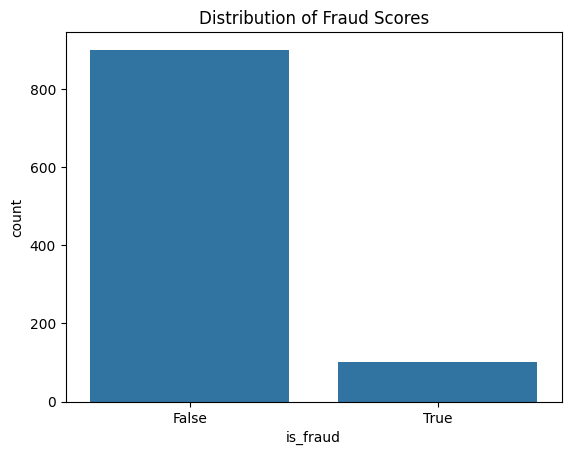

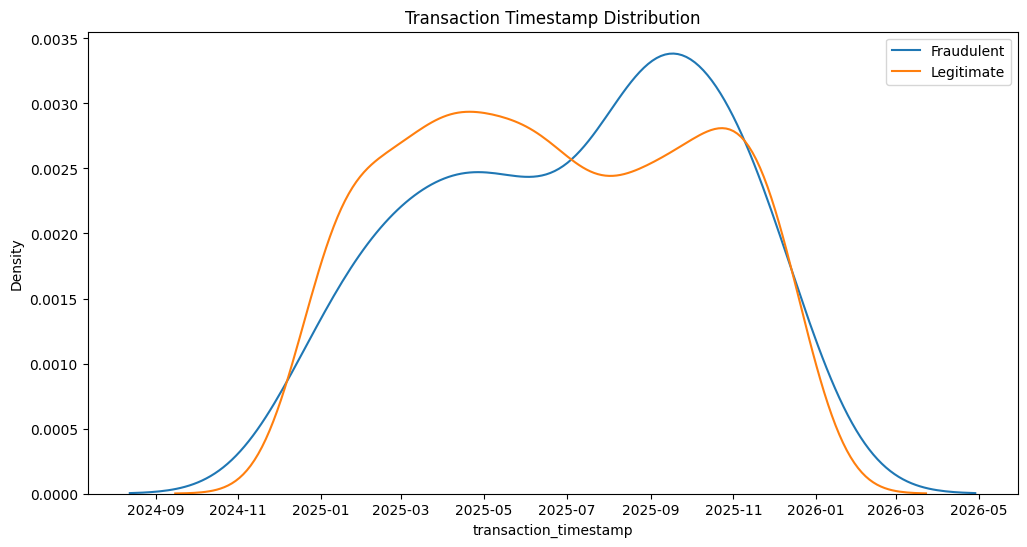

In [6]:
# Example: Distribution of fraud scores
sns.countplot(x='is_fraud', data=df)
plt.title('Distribution of Fraud Scores')
plt.show()

# Example: Timestamps of fraudulent vs legitimate transactions
plt.figure(figsize=(12,6))
sns.kdeplot(df[df['is_fraud']]['transaction_timestamp'], label='Fraudulent')
sns.kdeplot(df[~df['is_fraud']]['transaction_timestamp'], label='Legitimate')
plt.title('Transaction Timestamp Distribution')
plt.legend()
plt.show()